# <center> Shape analysis of cancer cells </center>

In this notebook, we study *Osteosarcoma* (bone cancer) cells and the impact of drug treatment on their *morphological shapes*, by analyzing cell images obtained from fluorescence microscopy . 

This analysis relies on the *elastic metric between discrete curves* that is implemented on Geomstats. We will study to which extent this metric can detect how the cell shape is associated with the response to treatment.

<td>
    <img src='cells_image.png'>
</td>

Figure 1: examples of cell shapes (Image credit : Ashok Prasad)

# 1. Introduction and motivation

Biological cells adopt a variety of shapes, determined by multiple processes and biophysical forces under the control of the cell. These shapes can be studied with different quantitative measures that reflect the cellular morphology (MGCKCKDDRTWSBCC2018). With the emergence of large-scale biological cell image data, morphological studies have many applications. For example, measures of irregularity and spreading of cells have been shown to allow accurate classification and discrimination between cancer cell lines treated with different drugs (AXCFP2019).

As a metric defined on the shape space of curves, the *elastic metric* (SKJJ2010), which is implemented in Geomstats, is another potential tool for analyzing and comparing biological cell shapes. While its associated geodesics and geodesic distances provide a natural framework for optimally matching, deforming, and comparing shapes, this metric, to our knowledge, has not been applied in this context so far. 

**References**

(MGCKCKDDRTWSBCC2018) McQuin C, Goodman A, Chernyshev V, Kamentsky L, Cimini BA, Karhohs KW, Doan M, Ding L, Rafelski SM, Thirstrup D, Wiegraebe W, Singh S, Becker T, Caicedo JC, Carpenter AE (2018). CellProfiler 3.0: Next-generation image processing for biology. PLoS Biol. 16(7):e2005970 / doi. PMID: 29969450

(AXCFP2019) Alizadeh E, Xu W, Castle J, Foss J, Prasad A. TISMorph: A tool to quantify texture, irregularity and spreading of single cells. PloS one. 2019 Jun 3;14(6):e0217346.

(SKJJ2010) Srivastava A, Klassen E, Joshi SH, Jermyn IH. Shape analysis of elastic curves in euclidean spaces. IEEE Transactions on Pattern Analysis and Machine Intelligence. 2010 Oct 14;33(7):1415-28.

# 2. Analysis

### Setup

In [138]:
import sys
!{sys.executable} -m pip install git+https://github.com/geomstats/geomstats.git
!{sys.executable} -m pip install opencv-python
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install scikit-learn

  Cloning https://github.com/geomstats/geomstats.git to /tmp/pip-req-build-l2qt5iim
  Running command git clone -q https://github.com/geomstats/geomstats.git /tmp/pip-req-build-l2qt5iim


  Created wheel for geomstats: filename=geomstats-2.2.3-py3-none-any.whl size=9551179 sha256=27694c0efaa7e6de513ce3485481d4723b448134aca2067d877a4dc636b85f7c
  Stored in directory: /tmp/pip-ephem-wheel-cache-e44tklnf/wheels/c1/18/96/0637d829ebefc4aa9e57006845538aa54f6c0e9619e6b56541
Successfully built geomstats


In [115]:
import warnings

warnings.filterwarnings('ignore')

In [116]:
import matplotlib
import matplotlib.pyplot as plt

import geomstats.backend as gs

## 2.1. Dataset description

We study a dataset of mouse *Osteosarcoma* imaged cells, provided by Professor Ashok Prasad (Colorado State University). The dataset contains two different cancer cell lines : *DLM8* and *DUNN* (AXCFP2019).  Among these cells, some have also been treated with different single drugs that perturb the cellular cytoskeleton. Overall, we can thus label each cell according to their cell line (*DLM8* and *DUNN*), and also if it is a control cell (no treatment), or has been treated with one of the following drugs : Jasp (jasplakinolide) and Cytd (cytochalasin D).

**Reference**

(AXCFP2019) Alizadeh E, Xu W, Castle J, Foss J, Prasad A. TISMorph: A tool to quantify texture, irregularity and spreading of single cells. PloS one. 2019 Jun 3;14(6):e0217346.

Each cell comes from a raw image containing a bunch of cells, which was thresholded to generate binarized images, as illustrated here:

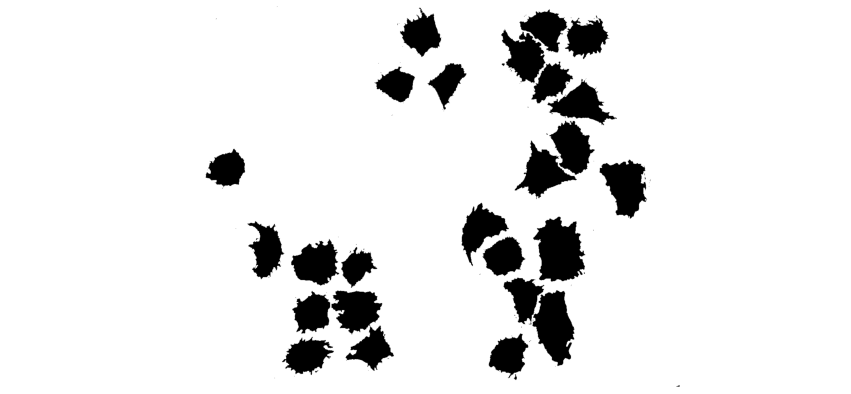

In [117]:
import cv2

img = cv2.imread('binary_image.tif')
plt.figure(figsize=(15, 7))
plt.axis('equal')
plt.axis('off')
plt.imshow(img)

Figure 2: Binarised image of cells

After binarizing the images, contouring was used to isolate each cell, and extract their boundaries as a counter-clockwise ordered list of 2D coordinates, which corresponds to the representation of discrete curve in Geomstats. In total, we obtain the following set of cells:

In [118]:
def load_cells():
    """Load cell data.

    Returns
    -------
    cells : list of 2D discrete curves
        Each curve represents the boundary of a cell, their lengths
        are not necessarily equal.
    cell_lines : array of strings
        List of the cell lines of each cell.
    treatments : array of strings
        List of the treatments given to each cell.
    """
    with open("cells.txt") as cells_file:
        cells = cells_file.read().split('\n\n')
    for i, cell in enumerate(cells):
        cell = cell.split('\n')
        curve = []
        for point in cell:
            coords = [int(coord) for coord in point.split()]
            curve.append(coords)
        cells[i] = gs.array(curve)
    with open("cell_lines.txt") as cell_lines_file:
        cell_lines = gs.array(cell_lines_file.read().split('\n'))
    with open("treatments.txt") as treatments_file:
        treatments = gs.array(treatments_file.read().split('\n'))
    return cells, cell_lines, treatments

In [119]:
cells, cell_lines, treatments = load_cells()
print(f'Total number of cells : {len(cells)}')

Total number of cells : 650


The cells are groupped by class in the dataset : first the control cells, then the cells treated with *Cytd* and finally the ones treated with *Jasp*. Also, in each class, the cells are groupped by cell line : first the *DLM8* cells and then the *DUNN* ones.

You can find the sizes of the different classes below :

In [120]:
for treatment in ["control", "cytd", "jasp"]:
    nb_dlm8 = gs.sum((treatments == treatment) & (cell_lines == "dlm8"))
    nb_dunn = gs.sum((treatments == treatment) & (cell_lines == "dunn"))
    print(f'{treatment} : {nb_dlm8} DLM8 and {nb_dunn} DUNN')

control : 114 DLM8 and 204 DUNN
cytd : 82 DLM8 and 93 DUNN
jasp : 62 DLM8 and 95 DUNN


## 2.2 Preprocessing Data

### Encoding discrete curves with same number of points

As we need discrete curves with the same number of sampled points to compute pairwise distances, the following interpolation is applied to each curve, after setting the number of sampling points.

We need discrete curves with the same number of sampled points in order to compute distances between them, which is why the following interpolation is needed in order to chose the amount of sampling points in each curve.

In [121]:
def interpolate(curve, nb_points):
    """Interpolate a discrete curve with nb_points from a discrete curve.

    Returns
    -------
    interpolation : discrete curve with nb_points points
    """
    old_length = curve.shape[0]
    interpolation = gs.zeros((nb_points, 2))
    incr = old_length/nb_points
    pos = 0
    for i in range(nb_points):
        index = int(gs.floor(pos))
        interpolation[i] = curve[index] + (pos - index)*(curve[(index + 1)%old_length] - curve[index])
        pos += incr
    return interpolation

nb_sampling = 100

(1116.375, 1229.125, -283.2620000000003, -199.178)

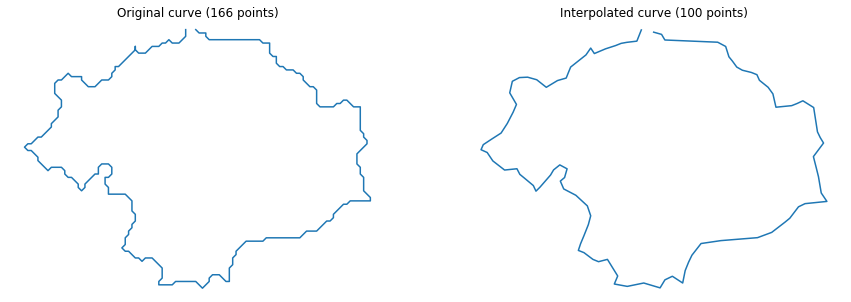

In [122]:
gs.random.seed(2021)

i = gs.random.randint(len(cells))
cell = cells[i]
cell_interpolation = interpolate(cells[i], nb_sampling)

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(cell[:, 0], cell[:, 1])
plt.axis('equal')
plt.title(f"Original curve ({len(cell)} points)")
plt.axis('off')

fig.add_subplot(122)
plt.plot(cell_interpolation[:, 0], cell_interpolation[:, 1])
plt.axis('equal')
plt.title(f"Interpolated curve ({nb_sampling} points)")
plt.axis('off')

In [123]:
for i in range(len(cells)):
    cells[i] = interpolate(cells[i], nb_sampling)

We can then plot a sample of control cells and a sample of treated cells:

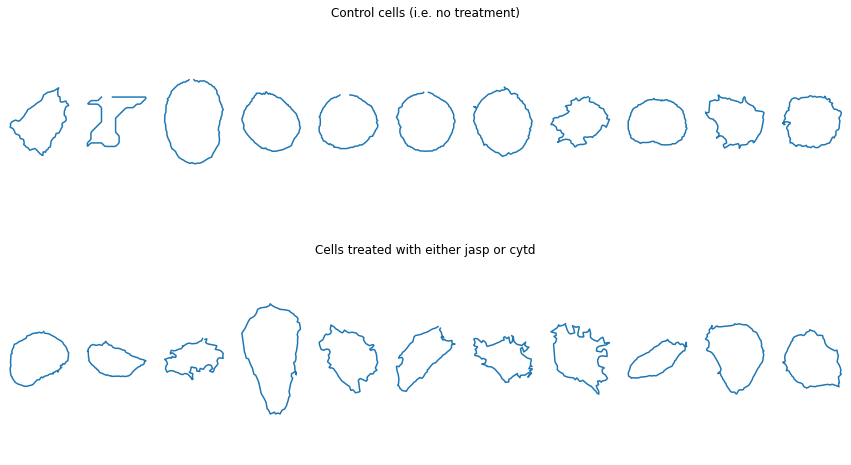

In [124]:
nb_cells = 11

control_i = gs.random.randint(0, 300, size=nb_cells)
jasp_i = gs.random.randint(500, 600, size=nb_cells)

fig = plt.figure(figsize=(15, 8))

for i in range(nb_cells):
    cell = cells[control_i[i]]
    fig.add_subplot(2, nb_cells, i + 1)
    plt.plot(cell[:, 0], cell[:, 1])
    if i == nb_cells//2:
        plt.title("Control cells (i.e. no treatment)")
    plt.axis('equal')
    plt.axis('off')
    
for i in range(nb_cells):
    cell = cells[jasp_i[i]]
    fig.add_subplot(2, nb_cells, i + nb_cells + 1)
    plt.plot(cell[:, 0], cell[:, 1])
    if i == nb_cells//2:
        plt.title("Cells treated with either jasp or cytd")
    plt.axis('equal')
    plt.axis('off')

### Reducing the effects of some transformations

Our goal is to study cell boundaries as points in a shape space of closed curves, quotiented by translation, scaling, and rotation transformations, so these do not affect our measure of distance between curves.

In practice, we apply functions that were initially designed to center (substract the barycenter), rescale (divide by the Frobenius norm) and then align (find the rotation minimizing the L² distance) two sets of landmarks. Since we are working with closed curves, the starting point associated with the parametrization of the discrete curves is also arbitrary. Thus, we conduct an exhaustive search to find which parametrization produces the best alignment according to the above procedure (i.e. the distance to the base curve is the smallest). 

After running this protocol to align all the curves of the dataset against the first one, our set of curves is now processed and ready for the analysis.

In [125]:
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric

m_ambient = 2
k_landmarks = nb_sampling

preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)
matrices_metric = preshape.embedding_metric

cells_preshape = preshape.projection(cells)

base_curve = cells_preshape[0]

def exhaustive_align(curve, base_curve):
    """Align curve to base_curve to minimize the L² distance.

    Returns
    -------
    aligned_curve : discrete curve
    """
    nb_sampling = len(curve)
    distances = gs.zeros(nb_sampling)
    for shift in range(nb_sampling):
        reparametrized = [curve[(i + shift)%nb_sampling] for i in range(nb_sampling)]
        aligned = preshape.align(point=reparametrized, base_point=base_curve)
        distances[shift] = matrices_metric.norm(gs.array(aligned) - gs.array(base_curve))
    shift_min = gs.argmin(distances)
    reparametrized_min = [curve[(i + shift_min)%nb_sampling] for i in range(nb_sampling)]
    aligned_curve = preshape.align(point=reparametrized_min, base_point=base_curve)
    return aligned_curve

cells_shape = [exhaustive_align(curve, base_curve) for curve in cells_preshape]

Text(0.5, 1.0, 'Aligned curve')

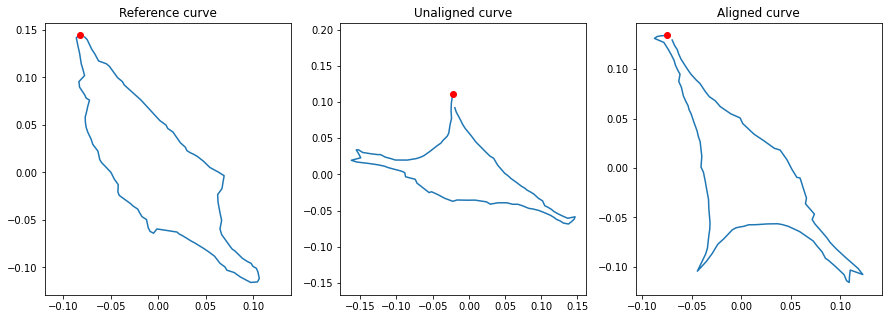

In [126]:
i = gs.random.randint(len(cells_shape))

base_cell = cells_preshape[0]
unaligned_cell = cells_preshape[i]
aligned_cell = cells_shape[i]

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(131)
plt.plot(base_cell[:, 0], base_cell[:, 1])
plt.plot(base_cell[0, 0], base_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Reference curve")

fig.add_subplot(132)
plt.plot(unaligned_cell[:, 0], unaligned_cell[:, 1])
plt.plot(unaligned_cell[0, 0], unaligned_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Unaligned curve")

fig.add_subplot(133)
plt.plot(aligned_cell[:, 0], aligned_cell[:, 1])
plt.plot(aligned_cell[0, 0], aligned_cell[0, 1], 'ro')
plt.axis('equal')
plt.title("Aligned curve")

In the above plot, the red dot is the start of the parametrization of each curve. We can see that the middle curve has been aligned with the curve on the left, which represents the first cell of the dataset. Moreover, the starting point (in red) of the curve has been modified during the process to get a better alignment.

## 2.3 Data analysis

### 2.3.A Single cell comparison

Thanks to Geomstats, we can compute geodesics between discrete curves with respect to the elastic metric. This is particularly relevant for cell boundaries as it corresponds to cell morphological trajectories which minimize an elastic energy. The distance that will be used in the rest of the notebook corresponds to the length of a geodesic between two curves. Here is a plot of a geodesic between two cells:

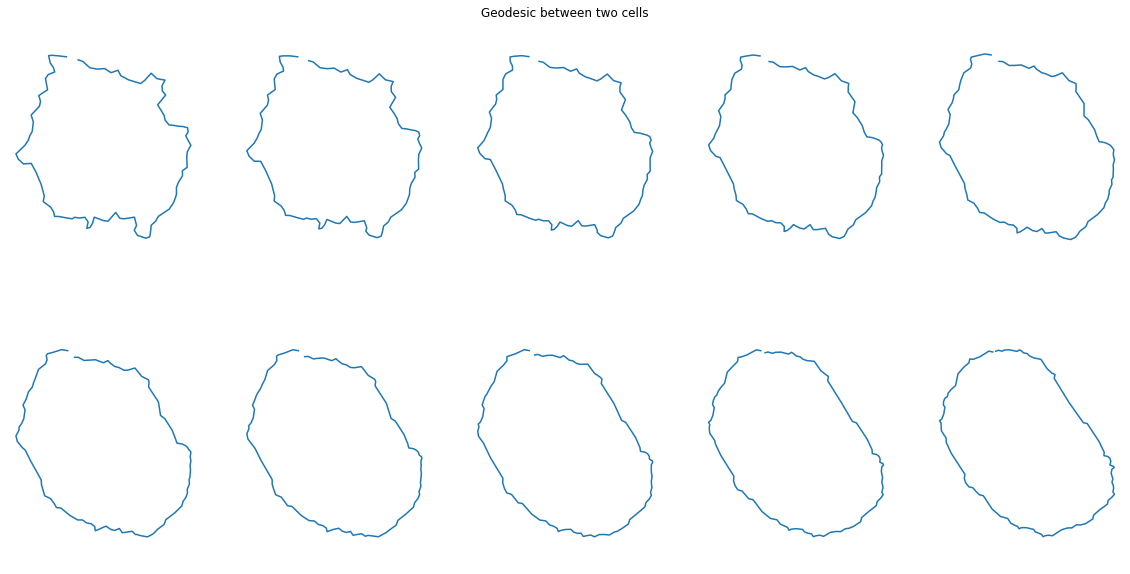

In [127]:
from geomstats.geometry.discrete_curves import R2, DiscreteCurves, SRVMetric

curves = DiscreteCurves(R2)
metric = curves.square_root_velocity_metric

gs.random.seed(1234)
i, j = gs.random.randint(len(cells_shape), size=2)

geodesic = metric.geodesic(initial_curve=cells_shape[i], end_curve=cells_shape[j])

points = geodesic(gs.linspace(0., 1., 10))

fig = plt.figure(figsize = (20, 10))
plt.title("Geodesic between two cells")
plt.axis('off')

for i, curve in enumerate(points):
    fig.add_subplot(2, len(points)/2, i + 1)
    plt.plot(curve[:, 0], curve[:, 1])
    plt.axis('equal')
    plt.axis('off')

### 2.3.B Multiple cell comparison

By computing L² distances between the square root velocities of the curves (note that it quotients out translations), we can compute the distance matrix of the dataset with respect to the elastic metric now that we reduced the effect of rotation and scaling. We did not use the dist function from Geomstats because it would have computed the same square root velocities too much times and because it takes the initial points of the curves into account, which we think is not relevant for this specific application because the starting point of a parametrization is arbitrary.

In [128]:
N = len(cells_shape)
srvs = [metric.square_root_velocity(cell) for cell in cells_shape]
dist_matrix = gs.zeros((N, N))

for i in range(N):
    for j in range(i, N):
        dist_matrix[i, j] = dist_matrix[j, i] = metric.l2_metric(nb_sampling - 1).dist(srvs[i], srvs[j])

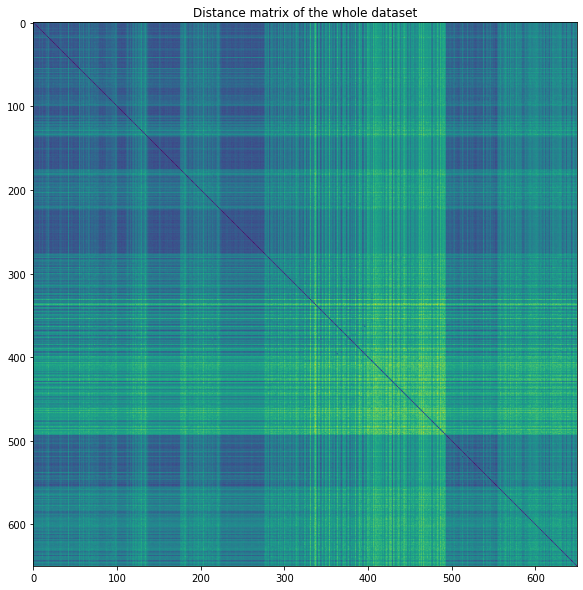

In [129]:
plt.figure(figsize=(10, 10))
plt.title("Distance matrix of the whole dataset")
plt.imshow(dist_matrix)

### Multidimensional scaling of the data

In [130]:
from sklearn import manifold
import numpy as np

mds = manifold.MDS(n_components=2, random_state = 1, dissimilarity="precomputed")
pos = mds.fit(dist_matrix).embedding_

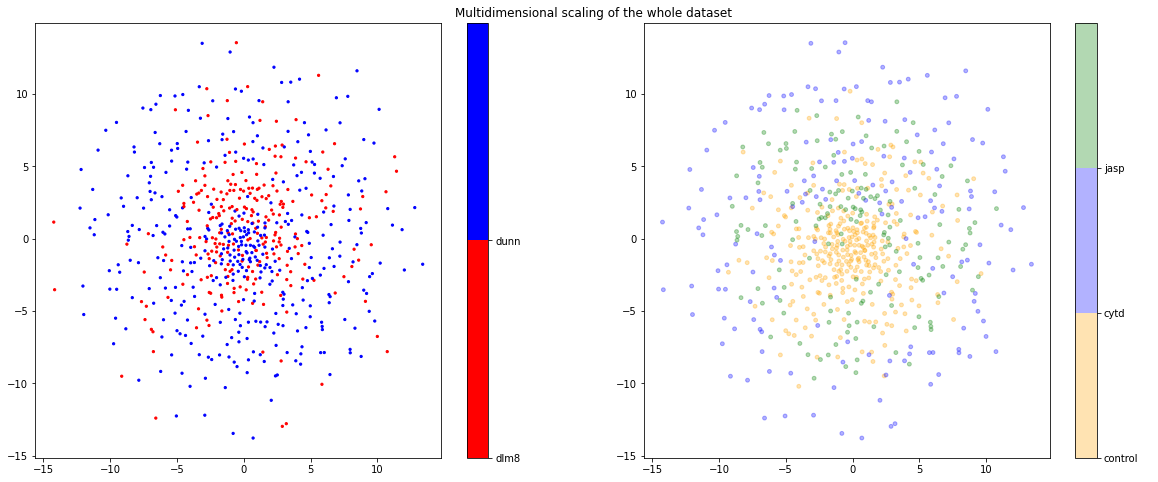

In [131]:
cell_lines_strings, cell_lines_labels = np.unique(cell_lines, return_inverse=True)
treatments_strings, treatments_labels = np.unique(treatments, return_inverse=True)

fig = plt.figure(figsize=(20, 8))
plt.title("Multidimensional scaling of the whole dataset")
plt.axis('off')

fig.add_subplot(121)
colors = ["red", "blue"]
plt.scatter(pos[:, 0], pos[:, 1], c=cell_lines_labels, cmap=matplotlib.colors.ListedColormap(colors), s=5)
cb = plt.colorbar()
loc = np.arange(0,max(cell_lines_labels),max(cell_lines_labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([cell_lines_strings[0], cell_lines_strings[1]])

fig.add_subplot(122)
colors = ["orange", "blue", "green"]
plt.scatter(pos[:, 0], pos[:, 1], c=treatments_labels, cmap=matplotlib.colors.ListedColormap(colors), alpha = 0.3, s=15)
cb = plt.colorbar()
loc = np.arange(0,max(treatments_labels),max(treatments_labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([treatments_strings[0], treatments_strings[1], treatments_strings[2]])

### Control vs treatment on DUNN cells

Number of jasp (first class) : 95
Number of cytd (second class) : 93


Text(0.5, 1.0, 'Dunn cells')

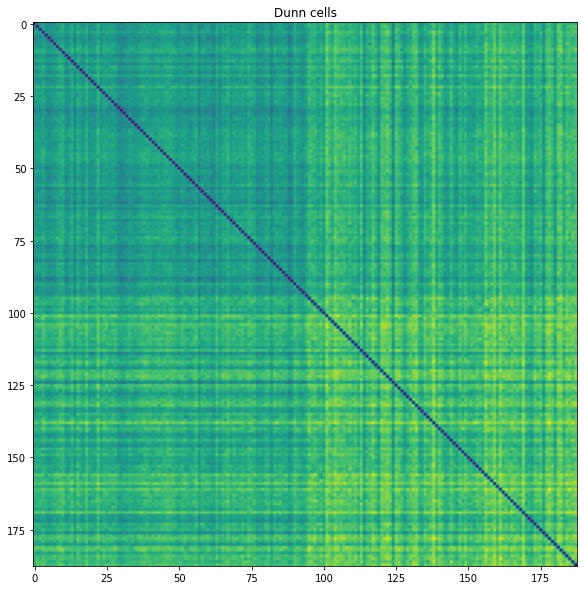

In [132]:
dunn_jasp_indexes = gs.where((cell_lines == "dunn") & (treatments == "jasp"))[0]
print("Number of jasp (first class) :", len(dunn_jasp_indexes))
dunn_cytd_indexes = gs.where((cell_lines == "dunn") & (treatments == "cytd"))[0]
print("Number of cytd (second class) :", len(dunn_cytd_indexes))

dunn_indexes = gs.concatenate((dunn_jasp_indexes, dunn_cytd_indexes))
dunn_matrix = dist_matrix[dunn_indexes][:, dunn_indexes]

plt.figure(figsize=(10, 10))
plt.imshow(dunn_matrix)
plt.title("Dunn cells")

### Treatments on DUNN cells

Number of jasp (first class) : 95
Number of cytd (second class) : 93
Number of control (third class) : 204


Text(0.5, 1.0, 'Dunn cells')

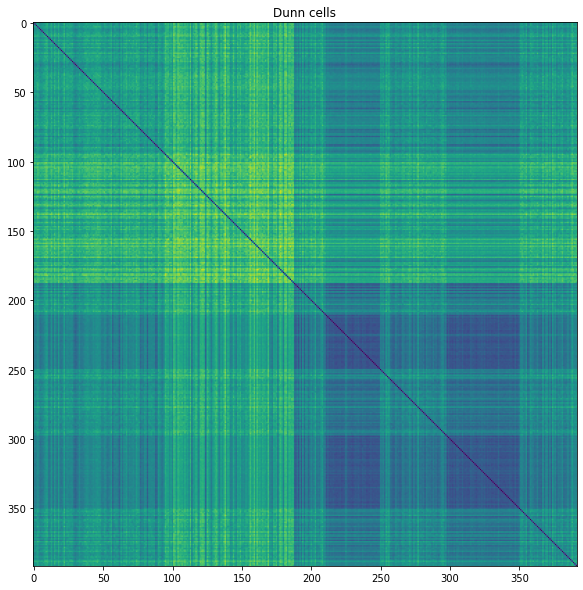

In [133]:
dunn_jasp_indexes = gs.where((cell_lines == "dunn") & (treatments == "jasp"))[0]
print("Number of jasp (first class) :", len(dunn_jasp_indexes))
dunn_cytd_indexes = gs.where((cell_lines == "dunn") & (treatments == "cytd"))[0]
print("Number of cytd (second class) :", len(dunn_cytd_indexes))
dunn_control_indexes = gs.where((cell_lines == "dunn") & (treatments == "control"))[0]
print("Number of control (third class) :", len(dunn_control_indexes))

dunn_indexes = gs.concatenate((dunn_jasp_indexes, dunn_cytd_indexes, dunn_control_indexes))
dunn_matrix = dist_matrix[dunn_indexes][:, dunn_indexes]

plt.figure(figsize=(10, 10))
plt.imshow(dunn_matrix)
plt.title("Dunn cells")

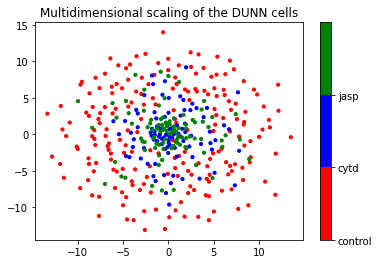

In [134]:
mds = manifold.MDS(n_components=2, random_state = 1, dissimilarity="precomputed")
pos = mds.fit(dunn_matrix).embedding_

dunn_treatments = treatments[cell_lines == "dunn"]

dunn_treatments_strings, dunn_treatments_labels = np.unique(dunn_treatments, return_inverse=True)
colors = ["red", "blue", "green"]

plt.title("Multidimensional scaling of the DUNN cells")
plt.scatter(pos[:, 0], pos[:, 1], c=dunn_treatments_labels, cmap=matplotlib.colors.ListedColormap(colors), s=10)

cb = plt.colorbar()
loc = np.arange(0,max(dunn_treatments_labels),max(dunn_treatments_labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([dunn_treatments_strings[0], dunn_treatments_strings[1], dunn_treatments_strings[2]])

In [135]:
from geomstats.learning.agglomerative_hierarchical_clustering import AgglomerativeHierarchicalClustering

clustering2 = AgglomerativeHierarchicalClustering(n_clusters = 2, distance='precomputed')
clustering2.fit(dunn_matrix)
print(clustering2.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


We can see a vague pattern on the matrix but the agglomerative clustering couldn't identify the labels. Unfortunately, the only point belonging to class 1 is not necessarily an outlier, the same thing happens with higher values for n_clusters and for other linking policies.

For other comparisons, the scenario is pretty much the same.

### Treatments on DLM8 cells

Number of jasp (first class) : 62
Number of cytd (second class) : 82
Number of control (third class) : 114


Text(0.5, 1.0, 'DLM8 cells')

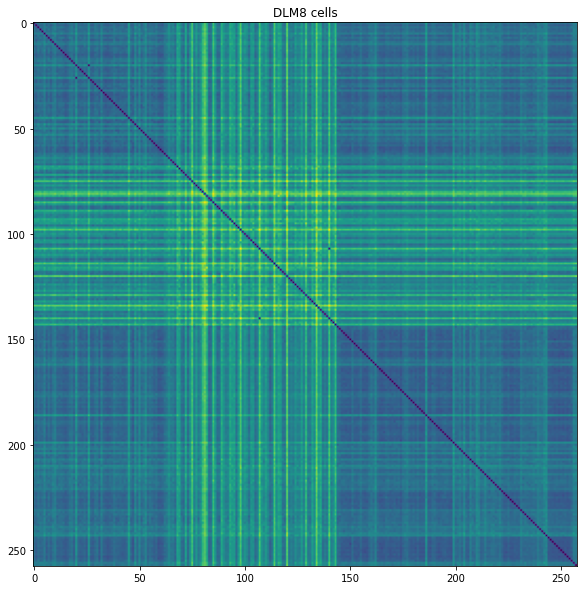

In [141]:
dlm8_jasp_indexes = gs.where((cell_lines == "dlm8") & (treatments == "jasp"))[0]
print("Number of jasp (first class) :", len(dlm8_jasp_indexes))
dlm8_cytd_indexes = gs.where((cell_lines == "dlm8") & (treatments == "cytd"))[0]
print("Number of cytd (second class) :", len(dlm8_cytd_indexes))
dlm8_control_indexes = gs.where((cell_lines == "dlm8") & (treatments == "control"))[0]
print("Number of control (third class) :", len(dlm8_control_indexes))

dlm8_indexes = gs.concatenate((dlm8_jasp_indexes, dlm8_cytd_indexes, dlm8_control_indexes))
dlm8_matrix = dist_matrix[dlm8_indexes][:, dlm8_indexes]

plt.figure(figsize=(10, 10))
plt.imshow(dlm8_matrix)
plt.title("DLM8 cells")

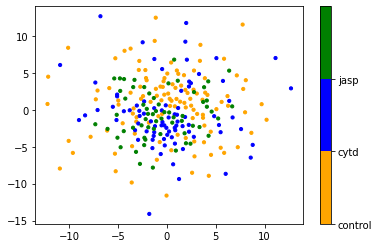

In [143]:
mds = manifold.MDS(n_components=2, random_state = 1, dissimilarity="precomputed")
pos = mds.fit(dlm8_matrix).embedding_

dlm8_treatments = treatments[cell_lines == "dlm8"]

dlm8_treatments_strings, dlm8_treatments_labels = np.unique(dlm8_treatments, return_inverse=True)
colors = ["orange", "blue", "green"]

plt.scatter(pos[:, 0], pos[:, 1], c=dlm8_treatments_labels, cmap=matplotlib.colors.ListedColormap(colors), s=10)

cb = plt.colorbar()
loc = np.arange(0,max(dlm8_treatments_labels),max(dlm8_treatments_labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([dlm8_treatments_strings[0], dlm8_treatments_strings[1], dlm8_treatments_strings[2]])

In [144]:
clustering3 = AgglomerativeHierarchicalClustering(n_clusters = 5, distance='precomputed')
clustering3.fit(dlm8_matrix)
print(clustering3.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Cell lines treated with jasp

Number of dunn (first class) : 95
Number of dlm8 (second class) : 62


Text(0.5, 1.0, 'jasp treatment')

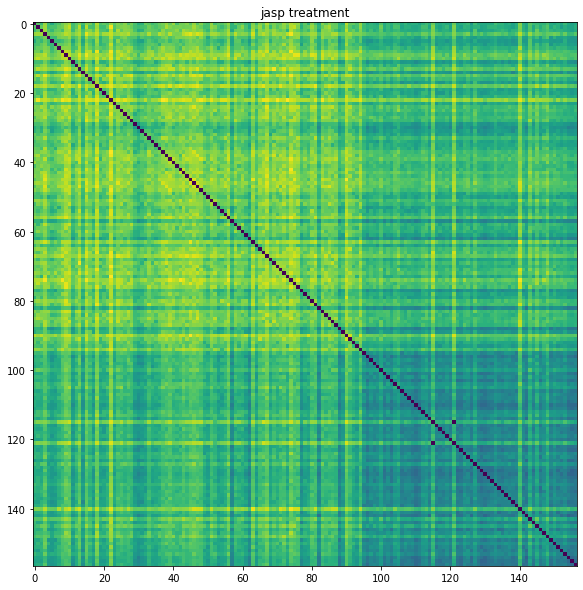

In [145]:
print("Number of dunn (first class) :", len(dunn_jasp_indexes))
print("Number of dlm8 (second class) :", len(dlm8_jasp_indexes))

jasp_indexes = gs.concatenate((dunn_jasp_indexes, dlm8_jasp_indexes))
jasp_matrix = dist_matrix[jasp_indexes][:, jasp_indexes]

plt.figure(figsize=(10, 10))
plt.imshow(jasp_matrix)
plt.title("jasp treatment")

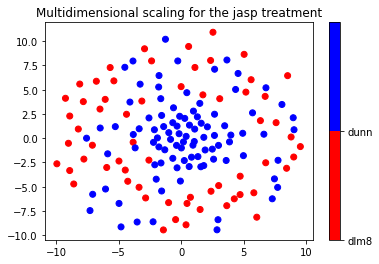

In [146]:
mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos = mds.fit(jasp_matrix).embedding_

jasp_cell_lines = cell_lines[treatments == "jasp"]

jasp_cell_lines_strings, jasp_cell_lines_labels = np.unique(jasp_cell_lines, return_inverse=True)
colors = ["red", "blue"]

plt.title("Multidimensional scaling for the jasp treatment")
plt.scatter(pos[:, 0], pos[:, 1], c=jasp_cell_lines_labels, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(jasp_cell_lines_labels),max(jasp_cell_lines_labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([jasp_cell_lines_strings[0], jasp_cell_lines_strings[1]])

In [147]:
clustering2 = AgglomerativeHierarchicalClustering(n_clusters = 5, distance='precomputed')
clustering2.fit(jasp_matrix)
print(clustering2.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Cell lines treated with cytd

Number of dunn (first class) : 93
Number of dlm8 (second class) : 82


Text(0.5, 1.0, 'cytd treatment')

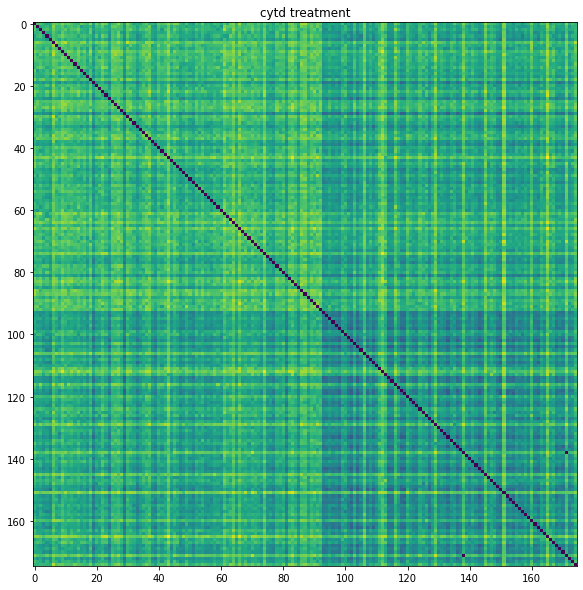

In [148]:
print("Number of dunn (first class) :", len(dunn_cytd_indexes))
print("Number of dlm8 (second class) :", len(dlm8_cytd_indexes))

cytd_indexes = gs.concatenate((dunn_cytd_indexes, dlm8_cytd_indexes))
cytd_matrix = dist_matrix[cytd_indexes][:, cytd_indexes]

plt.figure(figsize=(10, 10))
plt.imshow(cytd_matrix)
plt.title("cytd treatment")

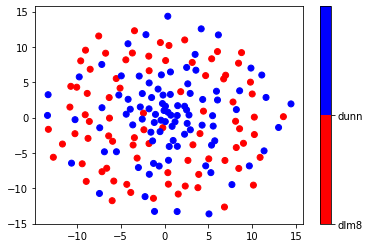

In [149]:
mds = manifold.MDS(n_components=2, random_state=1, dissimilarity="precomputed")
pos = mds.fit(cytd_matrix).embedding_

cytd_cell_lines = cell_lines[treatments == "cytd"]

cytd_cell_lines_strings, cytd_cell_lines_labels = np.unique(cytd_cell_lines, return_inverse=True)
colors = ["red", "blue"]

plt.scatter(pos[:, 0], pos[:, 1], c=cytd_cell_lines_labels, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(cytd_cell_lines_labels),max(cytd_cell_lines_labels)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels([cytd_cell_lines_strings[0], cytd_cell_lines_strings[1]])

In [150]:
clustering2 = AgglomerativeHierarchicalClustering(n_clusters = 2, distance='precomputed')
clustering2.fit(cytd_matrix)
print(clustering2.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Binary Classification

In [ ]:
#Control vs Drug, DLM8 vs DUNN

## 2.4. Role of Geomstats/Giotto-TDA in the analysis

In our analysis, Geomstats allowed us to compare discrete curves as points in a manifold, by computing geodesics and distances. If some features like tangent PCA or Fréchet mean were implemented for discrete curves, we could have used it in order to vizualize our data in a low-dimensional linear space. Moreover, we also used it in order to align the curves in order to reduce the effect of rotations on the data.

Unfortunately, we did not find any feature which is relevant for our data in the Giotto-TDA package.

# 3. Benchmark

raw vs preprocessed

# 4. Limitations and perspectives

### Limitations of this analysis

We chose to focus our analysis on the boundaries of the cells. However, there are a lot of other features that can be taken into account in order to analyze cell shapes such as the shape of the nucleus or the actin texture, and even geometric features like circularity or aspect ratio.

Since Geomstats lacks some features on discrete curves that would be relevant for this analysis, we had to preprocess the data in order to quotient out some transformations. However, this preprocessing is far from being perfect. Indeed, we used Geomstats' methods whose initial purpose is to preprocess sets of landmarks in order to work in Kendall's shape space, which is not exactly relevant for discrete curves because the space of elastic curves and Kendall's shape space use different metrics. Furthermore, our alignment procedure does an exhaustive search over every starting point of the parametrization, which can become unpractical for a higher numer of sampling points.

Also, we only studied cell images. However, cell shapes are continuously changing, and an interesting perspective would be to study videos of cells instead of static images in order to study morphological trajectories. This kind of analysis could then give us a better understanding of the shape spaces cells live in.  For instance, we could take a video of a cell just after a drug was administered in order to understand the effect of a drug on the morphological trajectories.

### Limitations of Geomstats

The first limitation that we faced is that Geomstats' current implementation only deals with open curves, which was not very clear to us when we first looked at the documentation. However, in order to work with cells, implementing closed curves in geomstats would be quite relevant as cell boundaries are naturally closed. In our analysis, cell boundaries were thus studied as open curves with Geomstats, which is why you can see some space between the two extreme points of the curves along a geodesic because there are no geometric constraints that prevent geodesics from containing non-closed curves.

In order to compare the curves, we had to preprocess the data in order to have a meaningful analysis because Geomstats doesn't consider that cells are defined up to transformations (such as rotations). As an example, we experimented with simple shapes (squares and circles) and the following behavior happened for two shapes with distant starting points (the red dot) because Geomstats cares about the starting points, which are not relevant for closed curves.

In [152]:
def unit_square(nb_points_side):
    """Generate a discrete curve representing a square 
    with nb_points_side sampling points by side.
    
    Returns
    -------
    square : discrete curve
    """
    nb_points = 2*(nb_points_side) + 2*(nb_points_side - 2)
    square = gs.zeros((nb_points, 2))
    
    pos_axis = gs.linspace(-1, 1, nb_points_side)
    neg_axis = gs.flip(pos_axis)
    ones = gs.ones(nb_points_side)
    minus_ones = -ones
    
    square[:nb_points_side] = gs.vstack((pos_axis, minus_ones)).T
    square[nb_points_side - 1 : 2*nb_points_side - 1] = gs.vstack((ones, pos_axis)).T
    square[2*nb_points_side - 2 : 3*nb_points_side - 2] = gs.vstack((neg_axis, ones)).T
    square[3*nb_points_side - 3 : 4*nb_points_side - 4] = gs.vstack((minus_ones, neg_axis)).T[:nb_points_side - 1]
    return square

def unit_circle(nb_points):
    """Generate a discrete curve with nb_points sampling points 
    representing the unit circle.
    
    Returns
    -------
    circle : discrete curve
    """
    t = gs.linspace(0, 2*gs.pi, nb_points + 1)[: -1]
    x = gs.cos(t)
    y = gs.sin(t)
    circle = gs.vstack((x, y)).T
    return circle

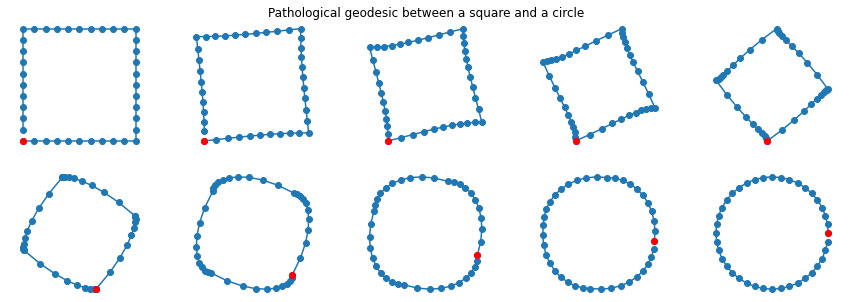

In [153]:
curves = DiscreteCurves(R2)
metric = curves.square_root_velocity_metric

square = unit_square(11)
circle = unit_circle(40)

geodesic = metric.geodesic(initial_curve=square, end_curve=circle)

points = geodesic(gs.linspace(0., 1., 10))

fig = plt.figure(figsize = (15, 5))
plt.title("Pathological geodesic between a square and a circle")
plt.axis('off')

for i in range(len(points)):
    fig.add_subplot(2, len(points)/2, i + 1)
    curve = points[i]
    plt.plot(curve[:, 0], curve[:, 1], '-o')
    plt.plot(curve[0, 0], curve[0, 1], 'ro')
    plt.axis('equal')
    plt.axis('off')

Also, I tried to project my dataset in 2D using a PCA on the tangent space at the Frechet mean as I saw in one of Geomstat's notebooks. However, I couldn't make it work because an exception was raised telling me the implementation was missing for this type of manifold.

Finally, since I came across cell classes with high variability in shape, I felt the need to do statistics in order to compare empirical variances between classes with statistical tests like an equivalent of Barlett's test (to test equality of variances). However, I did not succeed in computing Frechet means (to compute variances) for discrete curves with the current implementation of Geomstats (I got an error telling me something was not implemented yet). I tried to fix it by implementing a new inner_product method in the SRVMetric class in my local repository and I opened an issue (https://github.com/geomstats/geomstats/issues/995) about it to have a better understanding of the current implementation so as to be able to contribute to the package in an efficient way.<br>

### Proposed features of Geomstats

When looking for literature about shape analysis of curves, I found a few papers [insert papers] in which they propose methods to study shapes of curves as quotient spaces, by considering (open or closed) curves up to translation, scaling, rotation and reparametrization. Moreover, some of these papers use the square root velocity representation of curves, which is already implemented in Geomstats, which means that the current framework could possibly be adapted in order to deal with such spaces and to add closed curves to Geomstats.

In this study, we were particularly interested in the elastic metric, whose physical interpretation is quite relevant to the study of physical objects like cells. Furthermore, there is actually a family of elastic metrics because its definition depends on two parameters that quantify the cost of bending and stretching. An interesting perspective would then be to compare a video of a morphological cell trajectory with geodesics between the first and last shapes of the cell in order to estimate the parameters which describe the biological evolution of a cell shape. However, the elastic metric which is currently implemented in the square root velocity framework only corresponds to a specific couple of parameters. Thus, generalizing the implementation to be able to choose the parameters would be pretty useful to study morphological trajectories. For example, in [paper with generalization], a generalization of the square root velocity vector is proposed in order to be able to choose the parameters of the elastic metric.

## References